In [1]:

from ZoeDepth.utils.analysis_utils import *
import gc
from tqdm import tqdm
from time import time
from ZoeDepth.utils.inference_utils import *
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
from criteria import *
from ARKIT_raw import *
from utils_evaluator import *

ModuleNotFoundError: No module named 'ZoeDepth.utils.analysis_utils'

In [3]:
dataset_root = "/mnt/datasets/airkitdata/upsampling/Validation"
dataloader = create_dataloader(
    root_dir=dataset_root,
    batch_size=1,
    shuffle=True,
    num_workers=os.cpu_count() or 4
)

DataLoader utworzony dla 5599 próbek.


In [4]:
# torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)
# Triggers fresh download of MiDaS repo
# można zakomentować po 1. uruchomieniu

device = 'cuda'
conf = get_config("zoedepth_nk", "infer")
model = build_model(conf).to(device)

img_size [384, 512]


Using cache found in /home/szymonleszkiewicz/.cache/torch/hub/intel-isl_MiDaS_master
/home/szymonleszkiewicz/test-eksperymenty/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/szymonleszkiewicz/test-eksperymenty/venv/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt


/home/szymonleszkiewicz/test-eksperymenty/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Loaded successfully


In [5]:
def pnp_inference_adaptive(model, rgb_input, sparse_depth, pnp_iters=2, pnp_alpha=0.01,
                           alpha_adaptation=True, alpha_increase_factor=1.1, alpha_decrease_factor=0.8,
                           min_alpha=0.001, max_alpha=0.1, patience=2):
    """
    Plug-and-Play inference dla ZoeDepth z wykorzystaniem sparse depth i adaptacyjnym alpha
    """
    with torch.no_grad():
        pnp_z = model.pnp_forward_front(rgb_input)

    criterion = nn.L1Loss()
    # criterion = RMSELoss()

    initial_loss = None
    final_loss = None
    previous_loss = None
    loss_history = []
    alpha_history = []
    current_alpha = pnp_alpha
    no_improvement_count = 0
    best_loss = float('inf')
    baseline_loss = None

    # Dodanie paska postępu tqdm
    for pnp_i in range(pnp_iters):

        if pnp_i != 0:
            pnp_z = pnp_z - current_alpha * torch.sign(pnp_z_grad)

        pnp_z = pnp_z.clone().detach().requires_grad_(True)

        output = model.pnp_forward_rear(pnp_z)
        if pnp_i == 0:
            ori_output = {key: value.clone().detach() for key, value in
                          output.items()}

        pred_depth = output['metric_depth']

        pred_depth = F.interpolate(
            pred_depth,
            size=(sparse_depth.shape[-2], sparse_depth.shape[-1]),
            mode='bilinear',
            align_corners=False
        )

        sparse_mask = sparse_depth > 0
        valid_points = sparse_mask.sum().item()

        if valid_points > 0:
            if pnp_i < pnp_iters - 1:
                pred_valid = torch.masked_select(pred_depth, sparse_mask)
                depth_valid = torch.masked_select(sparse_depth, sparse_mask)
                pnp_loss = criterion(pred_valid, depth_valid)

                if initial_loss is None:
                    initial_loss = pnp_loss.item()
                    best_loss = initial_loss

                current_loss = pnp_loss.item()
                final_loss = current_loss
                loss_history.append(current_loss)
                alpha_history.append(current_alpha)

                # Aktualizacja alpha przy użyciu wydzielonej funkcji
                if alpha_adaptation:
                    new_alpha, best_loss, no_improvement_count, message = alpha_actualization(
                        current_alpha, previous_loss, current_loss, best_loss, no_improvement_count,
                        alpha_increase_factor, alpha_decrease_factor, min_alpha, max_alpha, patience
                    )
                    current_alpha = new_alpha
                    # if message:
                    #     print(message)

                previous_loss = current_loss

                try:
                    pnp_z_grad = torch.autograd.grad(pnp_loss, pnp_z, create_graph=False, allow_unused=True)[0]

                    if pnp_z_grad is None:
                        print("WARNING: No gradients computed, stopping")
                        break

                except RuntimeError as e:
                    print(f"Gradient computation failed: {e}")
                    break
            else:
                with torch.no_grad():
                    pred_valid = torch.masked_select(pred_depth, sparse_mask)
                    depth_valid = torch.masked_select(sparse_depth, sparse_mask)
                    pnp_loss = criterion(pred_valid, depth_valid)
                    final_loss = pnp_loss.item()
                    loss_history.append(final_loss)
                    alpha_history.append(current_alpha)


        else:
            print("No sparse points found - breaking")
            break

    return output, ori_output, initial_loss, final_loss

In [6]:
def inference(model, dataloader, folder_name="test"):
    initial_losses, pnp_losses = [], []
    i = 0
    for batch in tqdm(dataloader):
        t1 = time()
        pnp, zoe, zoe_loss, pnp_loss = pnp_inference_adaptive(
            model=model,
            rgb_input=batch['image'].to(device),
            sparse_depth=batch['sparse_depth'].to(device),
            pnp_iters=15,
            pnp_alpha=5,  # Początkowa wartość
            alpha_adaptation=True,  # Włącz adaptację
            alpha_increase_factor=1,  # wieksze -> agresywniej zwiekszaj
            alpha_decrease_factor=0.7,
            min_alpha=0.001,
            max_alpha=8,
            patience=2
        )

        gt = batch['ground_truth'].to(device)
        interpolate_output = lambda prediction: F.interpolate(
            prediction,
            size=(gt.shape[-2], gt.shape[-1]),
            mode='bilinear',
            align_corners=False
        )

        # Zapisywanie  mertryk
        baseline_metrics = baseline_evaluator.compute_metrics(interpolate_output(zoe['metric_depth']), gt)
        baseline_evaluator.update(baseline_metrics)
        modified_metrics = modified_evaluator.compute_metrics(interpolate_output(pnp['metric_depth']), gt)
        modified_evaluator.update(modified_metrics)

        i+=1
        initial_losses.append(zoe_loss)
        pnp_losses.append(pnp_loss)
        gc.collect()
        torch.cuda.empty_cache()
        if i == 25:
            break
    return initial_losses, pnp_losses

In [6]:
baseline_evaluator = DepthEvaluator()
modified_evaluator = DepthEvaluator()
zoe_loss, pnp_loss = inference(model, dataloader)

  0%|          | 24/5599 [00:35<2:17:19,  1.48s/it]


In [7]:
eval_zoe = baseline_evaluator.get_results()
eval_pnp = modified_evaluator.get_results()

In [8]:
headers = ["Metryka", "Baseline", "PnP", "Zmiana % (PnP vs Baseline)"]

table_data = []
for key in eval_zoe:
    baseline_val = eval_zoe[key].item()
    pnp_val = eval_pnp[key].item()

    if baseline_val != 0:
        percentage_change = ((pnp_val - baseline_val) / baseline_val) * 100
    else:
        percentage_change = float('inf') if pnp_val != 0 else 0.0

    table_data.append([
        key,
        baseline_val,
        pnp_val,
        f"{percentage_change:.2f}%"
    ])

print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".6f", ".6f", ".6f", "")))

+-----------+------------+----------+------------------------------+
| Metryka   |   Baseline |      PnP | Zmiana % (PnP vs Baseline)   |
+===========+============+==========+==============================+
| RMSE      |   0.756174 | 0.499735 | -33.91%                      |
+-----------+------------+----------+------------------------------+
| MAE       |   0.696305 | 0.421651 | -39.44%                      |
+-----------+------------+----------+------------------------------+
| delta1    |   0.195074 | 0.756003 | 287.55%                      |
+-----------+------------+----------+------------------------------+
| delta2    |   0.436779 | 0.848328 | 94.22%                       |
+-----------+------------+----------+------------------------------+
| delta3    |   0.681434 | 0.891431 | 30.82%                       |
+-----------+------------+----------+------------------------------+


In [32]:
test_batch = next(iter(dataloader))
img_test = test_batch['image'].to(device)
depth_test = test_batch['sparse_depth'].to(device)
gt_test = test_batch['ground_truth'].to(device)

In [33]:
pnp, zoe, original_loss, improved_loss = pnp_inference_adaptive(
    model=model,
    rgb_input=img_test,
    sparse_depth=depth_test,
    pnp_iters=20,
    pnp_alpha=6,  # Początkowa wartość
    alpha_adaptation=True,  # Włącz adaptację
    alpha_increase_factor=1,  # wieksze -> agresywniej zwiekszaj
    alpha_decrease_factor=0.7,
    min_alpha=0.001,
    max_alpha=5,
    patience=2
)

Using GT-based color scale: 0.612 - 1.324m (percentile: 99%)


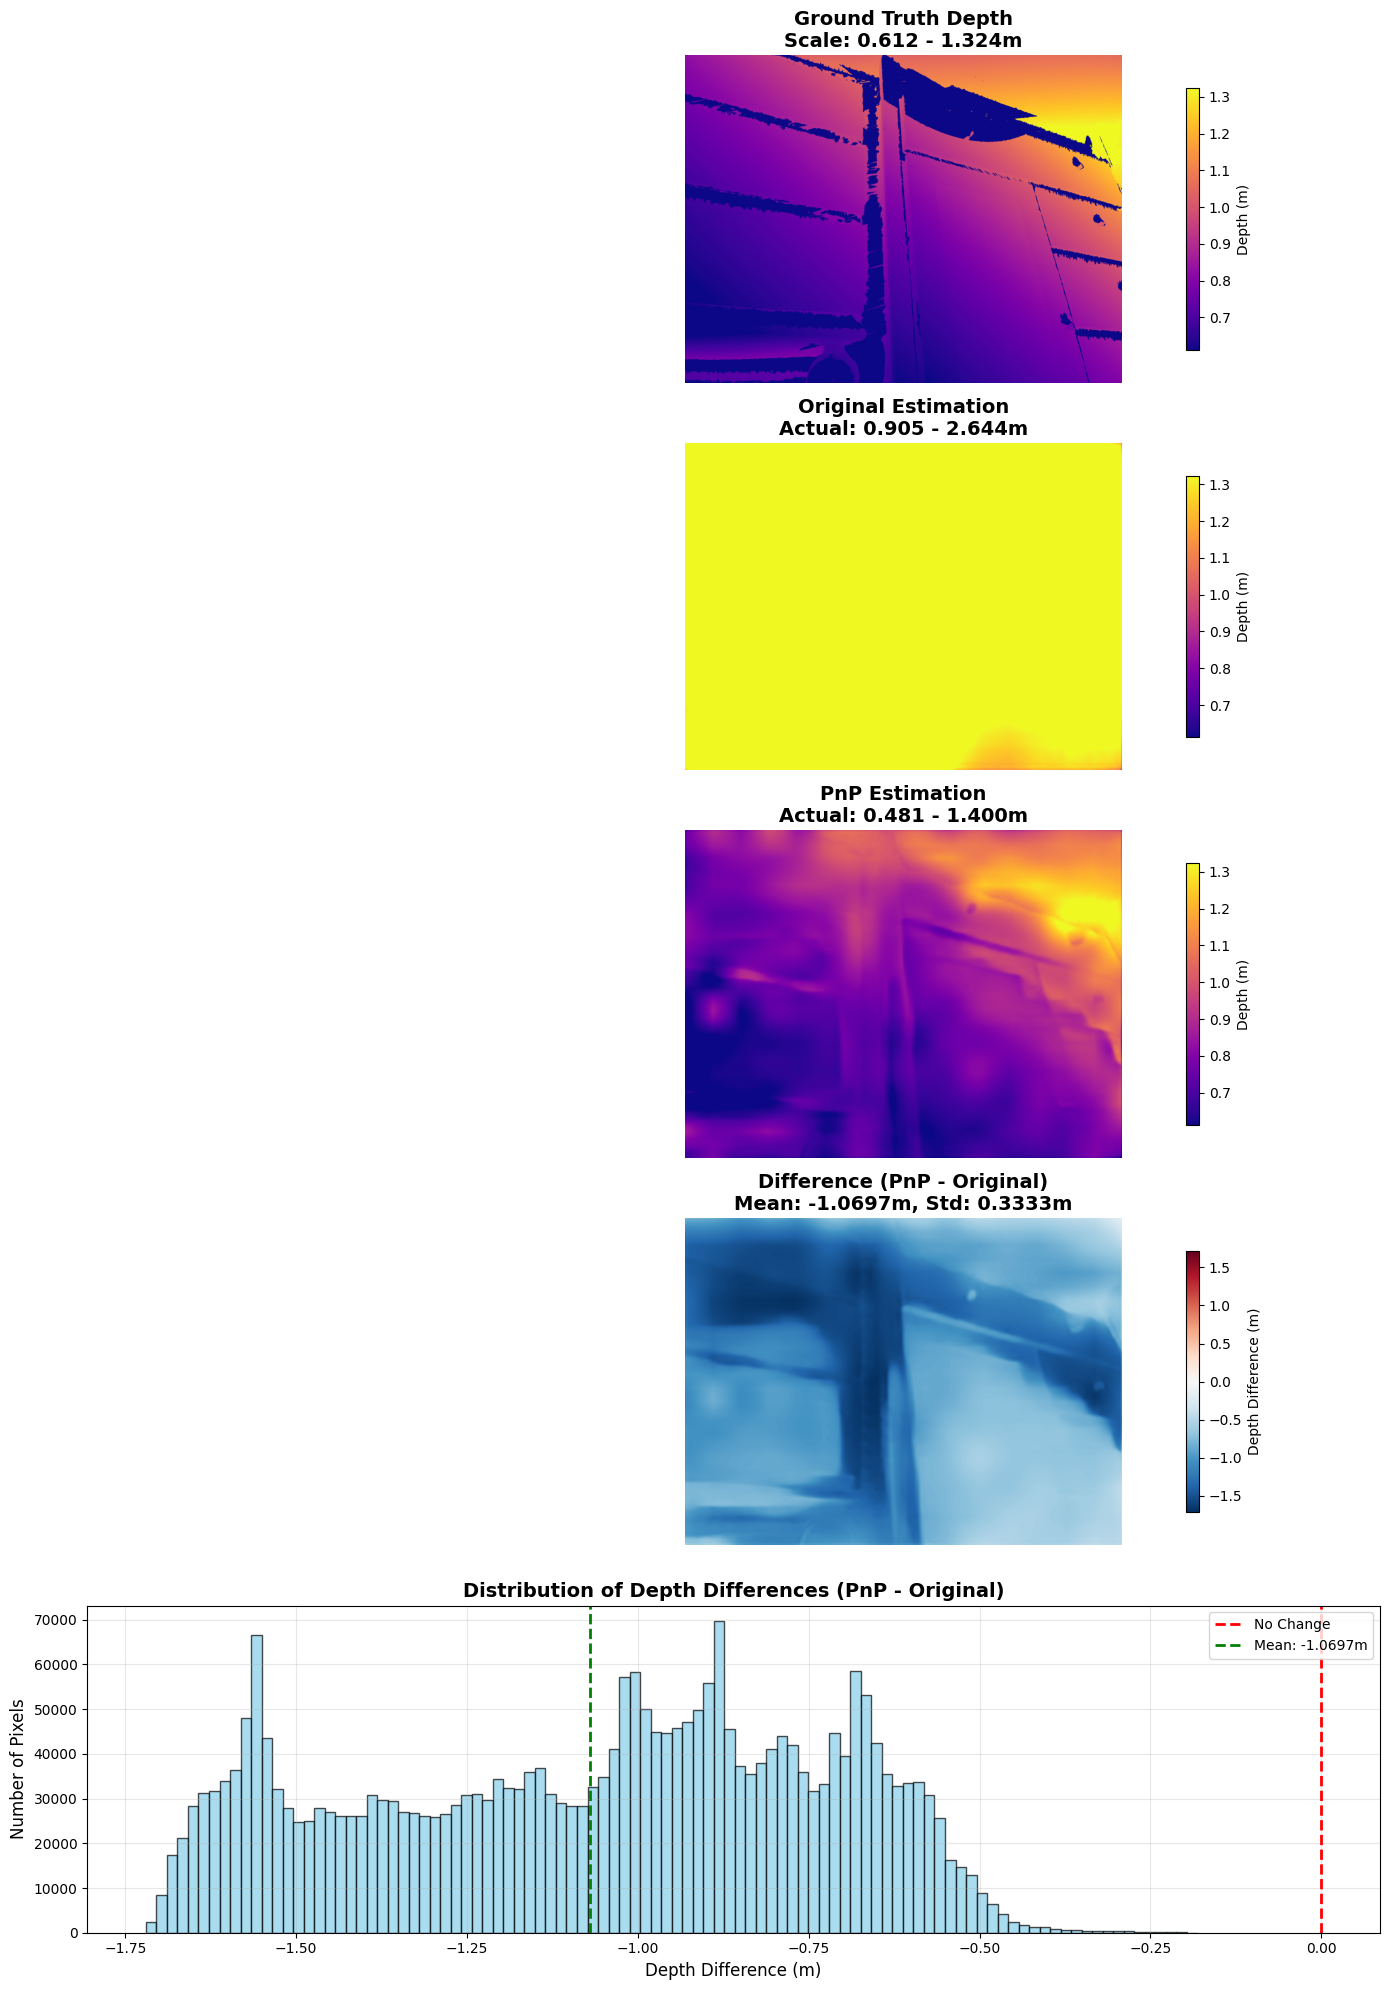

In [34]:
plot_depth_comparison(gt_test,
                      zoe['metric_depth'],
                      pnp['metric_depth'],
                      method_name="PnP")

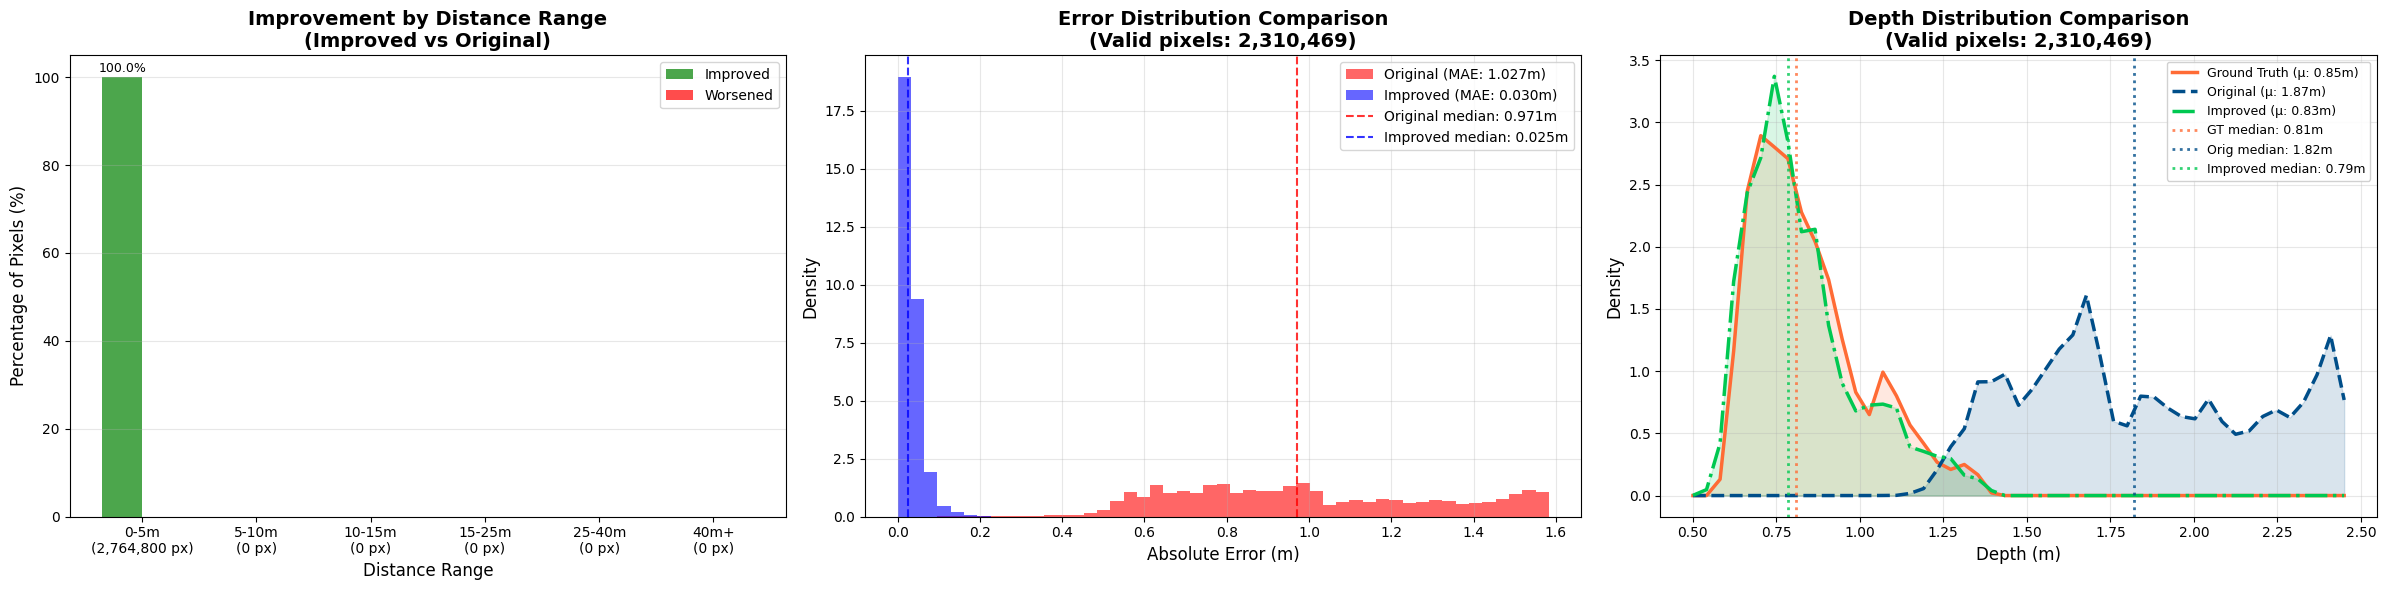


=== DETAILED ANALYSIS (Improved) ===
Threshold for significant change: 0.010m

Overall Performance:
  MAE improvement: 0.9967m (1.0271m → 0.0304m)
  RMSE improvement: 1.0408m (1.0803m → 0.0396m)
  Pixels improved: 2,764,675 (100.0%)
  Pixels worsened: 91 (0.0%)

Depth Distribution Statistics:
  Ground Truth    - Mean: 0.847m, Median: 0.808m, Std: 0.168m
  Original        - Mean: 1.874m, Median: 1.820m, Std: 0.376m
  Improved       - Mean: 0.828m, Median: 0.785m, Std: 0.167m

Depth Range Analysis:
  Ground Truth    - Range: 0.57m - 1.41m
  Original        - Range: 0.90m - 2.64m
  Improved       - Range: 0.48m - 1.40m


In [35]:
plot_detailed_analysis(
    gt_test,
    zoe['metric_depth'],
    pnp['metric_depth'])

Using GT-based color scale: 0.612 - 1.324m (percentile: 99%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].


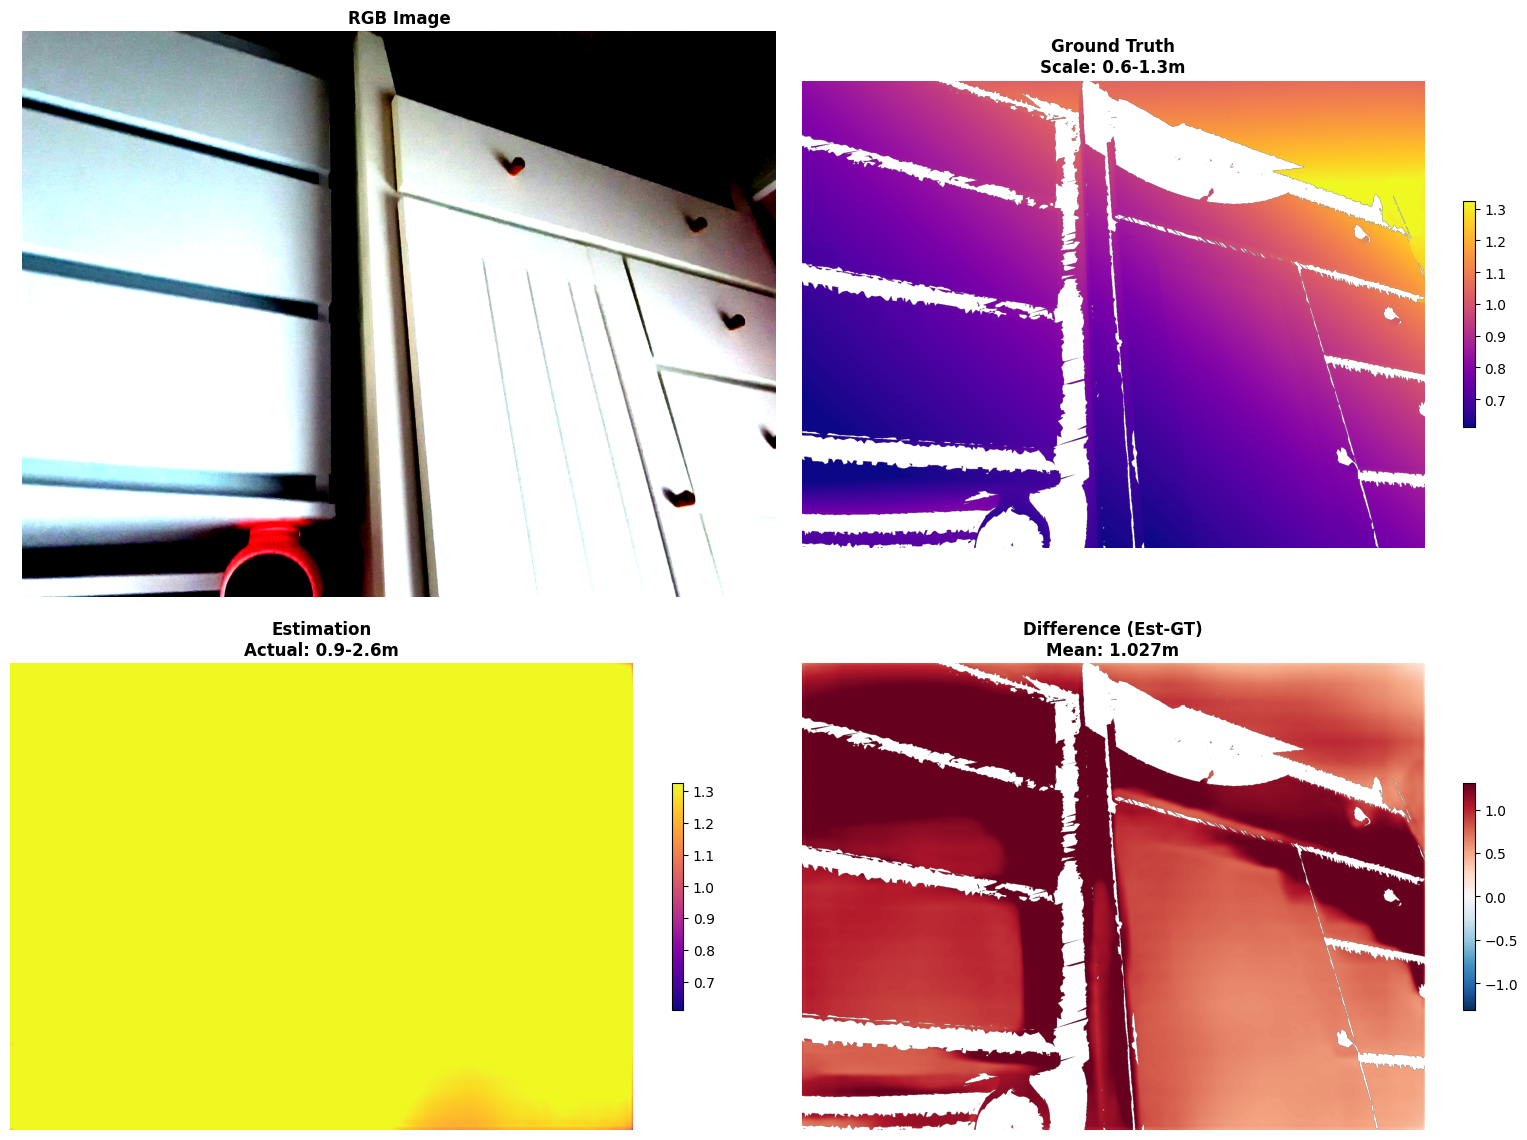

MAXXXXX 1.5826272

=== DEPTH COMPARISON METRICS ===
Color scale mode: GT-based (0.612 - 1.324m)
Estimation pixels outside GT scale: 2,667,127 (96.5%)
MAE: 1.0271m
RMSE: 1.0803m
Bias: 1.0271m
Valid pixels: 2,310,469/2,764,800 (83.6%)

Scale Information:
  GT scale used: 0.612 - 1.324m
  GT actual range: 0.573 - 1.408m
  Estimation actual range: 0.905 - 2.644m


In [36]:
visualize_depth_comparison(gt_test, zoe['metric_depth'], image=img_test, user_max=1.2997868, user_min=-1.2997868)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].


Using GT-based color scale: 0.612 - 1.324m (percentile: 99%)


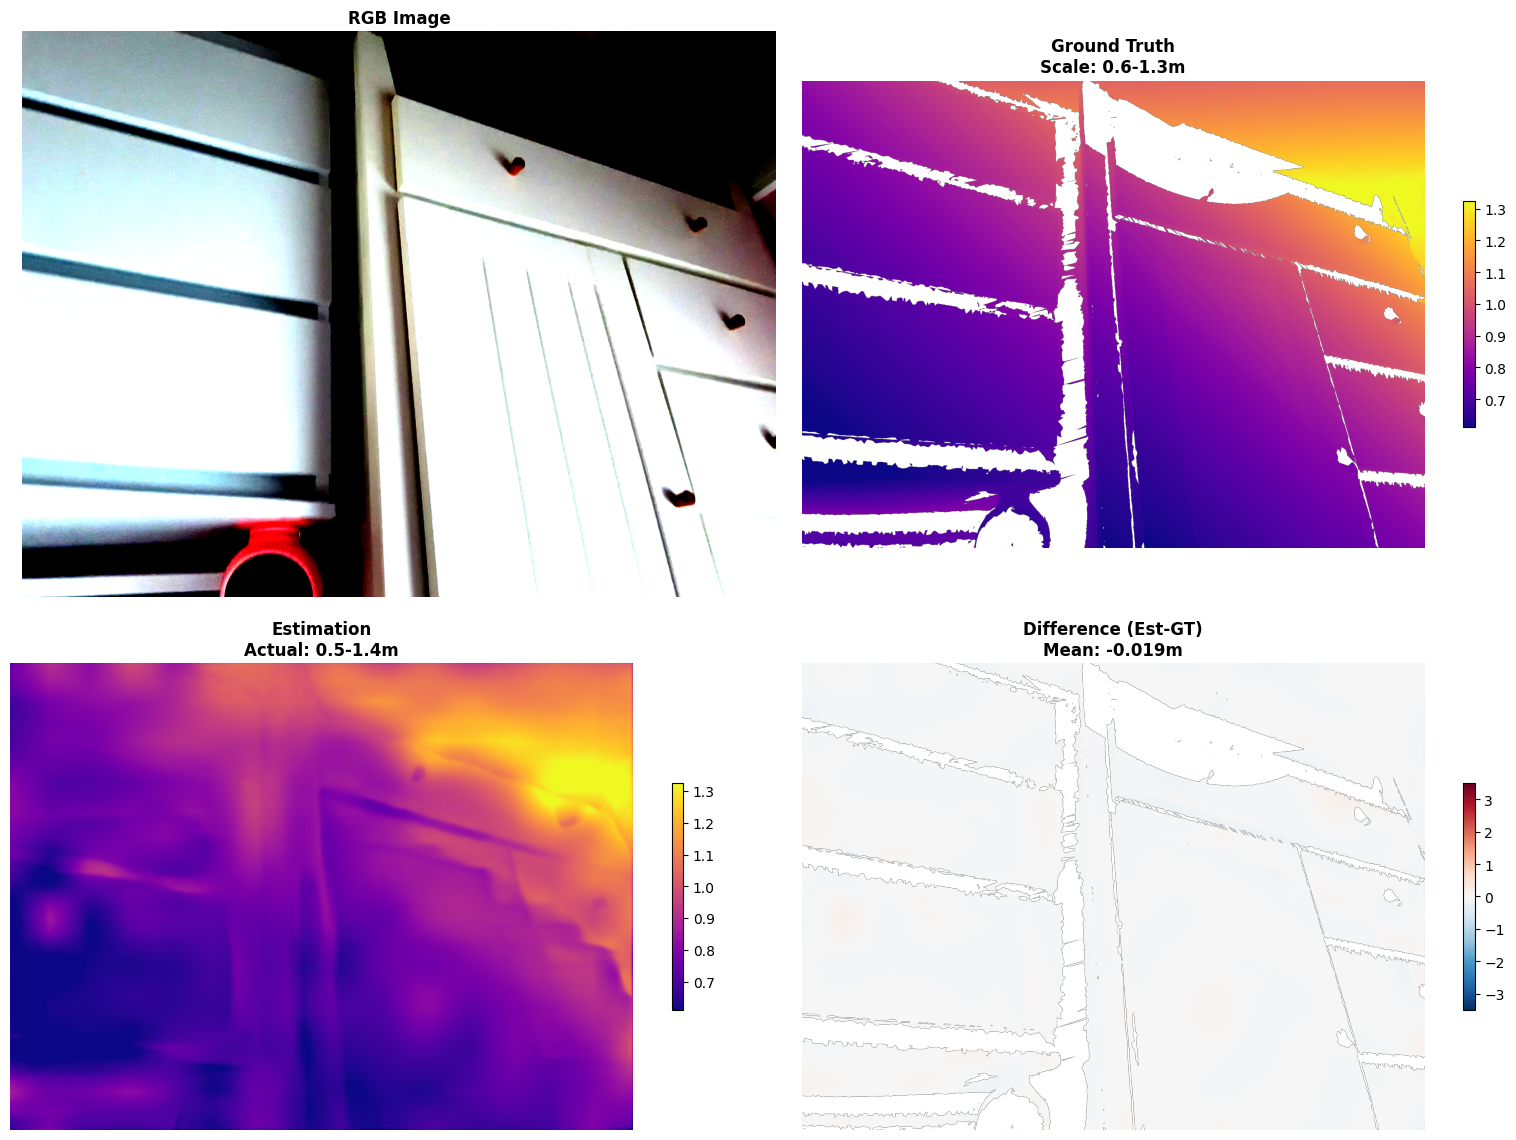

MAXXXXX 0.07638261


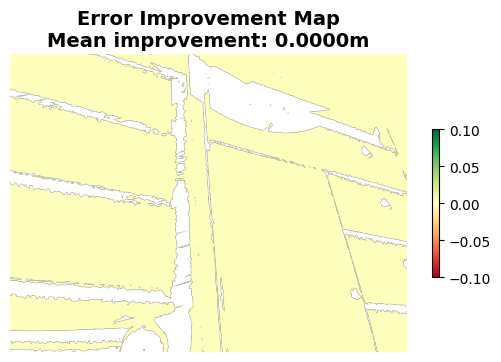


=== DEPTH COMPARISON METRICS ===
Color scale mode: GT-based (0.612 - 1.324m)
Estimation pixels outside GT scale: 107,889 (3.9%)
MAE: 0.0304m
RMSE: 0.0396m
Bias: -0.0187m
Valid pixels: 2,310,469/2,764,800 (83.6%)

Scale Information:
  GT scale used: 0.612 - 1.324m
  GT actual range: 0.573 - 1.408m
  Estimation actual range: 0.481 - 1.400m


In [37]:
visualize_depth_comparison(gt_test, pnp['metric_depth'], pnp['metric_depth'], image=img_test, user_max=3.4952376, user_min=-3.4952376)
